In [2]:
import pandas as pd
import numpy as np

#utils
import os, random, time

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

#CV
from sklearn.model_selection import cross_validate

#Feature Selection
from sklearn.feature_selection import chi2

#Doc2Vec
import gensim
import gensim.downloader as api

#pycaret
from pycaret.classification import *
from pycaret.utils import check_metric

# Teste 1: Doc2vec

- Pre-processamento: Remoção de stopwords, emojis e pontuação
- Data Augmentatation: Não
- Vetrizacao: doc2vec
- Selecao de Atributos: Não

In [34]:
dataset = pd.read_csv('C:/Users/lmb3/source/repos/OurClassifier/pycaret tutorials/data_processed/stopwordPuncEmojitRemoval_dataset.csv', index_col=0)

In [35]:
dataset

,text,misinformation,pre_processed_text
0,"No dia 07 de Outubro, quando for votar, não es...",1,no dia 07 outubro votar esqueça esquerdopatas ...
1,Devido a aborrecimentos nas varias redes socia...,0,devido aborrecimentos varias redes sociais pos...
2,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0,eu gostaria pedir todos grupos entrem neste li...
3,Como são as coisas.\nChefe do jacaré aparece n...,1,como coisas chefe jacaré aparece video baleado...
4,A ratoeira funcionou mais a ratazana aguentou ...,0,a ratoeira funcionou ratazana aguentou dor cal...
...,...,...,...
4583,Amoedo - Itaú - Metacapitalistas (George Soros...,1,amoedo itaú metacapitalistas george soros gove...
4584,*BEM GALERA... O VIDEO DA PSICOLOGIA REVERSA P...,0,bem galera video psicologia reversa ajudar pr...
4585,DIVULGUEM ESSE VIDEO PARA QUE TODOS SAIBAM QUE...,1,divulguem video todos saibam bolsonaro 🇧🇷
4586,https://www.oantagonista.com/brasil/exclusivo-...,0,www oantagonista exclusivo bolsonaro faz nova ...


In [36]:
#Mudando o nome da coluna prpcessed_text e dropando o texto original
dataset.drop('text',axis=1, inplace=True)
dataset.rename(columns = {'pre_processed_text':'text'}, inplace = True)
dataset

,misinformation,text
0,1,no dia 07 outubro votar esqueça esquerdopatas ...
1,0,devido aborrecimentos varias redes sociais pos...
2,0,eu gostaria pedir todos grupos entrem neste li...
3,1,como coisas chefe jacaré aparece video baleado...
4,0,a ratoeira funcionou ratazana aguentou dor cal...
...,...,...
4583,1,amoedo itaú metacapitalistas george soros gove...
4584,0,bem galera video psicologia reversa ajudar pr...
4585,1,divulguem video todos saibam bolsonaro 🇧🇷
4586,0,www oantagonista exclusivo bolsonaro faz nova ...


## Doc2Vec

In [37]:
def doc2vec(text_df):

    list_text = list(text_df['text'])
    for (index, text) in enumerate(list_text):
        if type(text) is list:
            text = " ".join(text)
        text = [i for i in text.split()]
        list_text[index] = text
    text_df.drop('text', axis=1, inplace=True)
    text_df['text'] = list_text

    data = [d for d in list(text_df['text'])]

    def tagged_document(list_of_list_of_words):
        for i, list_of_words in enumerate(list_of_list_of_words):
            yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
    
    data_for_training = list(tagged_document(data))
    
    model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=2, epochs=50)
    model.build_vocab(data_for_training)
    model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)
    
    def vec_for_learning(doc2vec_model, tagged_docs):
        targets, regressors = zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words)) for doc in tagged_docs])
        return targets, regressors

    targets, X_doc2vec_train = vec_for_learning(model, data_for_training)
    
    d2v_df = pd.DataFrame(X_doc2vec_train)
    d2v_df.insert(len(d2v_df.columns), 'target',  text_df['misinformation'].reset_index(drop=True))
    return d2v_df

In [38]:
d2v_df = doc2vec(dataset)
d2v_df

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,target
0,-0.010414,-0.048100,-0.150560,-0.006941,-0.064847,0.009186,0.089741,0.245171,0.132609,-0.190448,...,0.000134,0.098481,0.057989,-0.011557,-0.114224,0.099819,-0.002840,-0.030174,-0.142168,1
1,0.042619,0.115376,-0.083589,0.020080,-0.302283,0.084633,-0.039546,0.014323,0.194234,0.083705,...,-0.027274,-0.163332,0.008768,0.033677,0.023242,-0.228501,0.088017,-0.147078,-0.058739,0
2,-0.063950,-0.163732,-0.297834,0.144044,-0.185401,-0.105788,-0.053724,0.181715,-0.325292,-0.090954,...,-0.105405,0.315806,-0.082494,0.343677,0.162500,0.021159,-0.039026,0.229368,-0.128226,0
3,0.207499,0.250753,-0.249867,0.017849,0.310193,0.152209,-0.129040,0.334205,0.003554,-0.009409,...,-0.194995,0.017520,-0.155609,0.031764,0.112051,0.061412,0.099003,0.017328,-0.255095,1
4,0.024521,-0.094251,0.127439,0.047826,-0.132290,0.087832,-0.032597,0.114632,0.061206,-0.092930,...,-0.186107,0.041540,0.132366,0.139221,0.067741,0.070096,0.098160,0.035823,0.015392,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583,0.171008,0.625088,-1.125686,0.452985,-2.162314,-1.600656,1.337677,-1.111116,0.607232,-0.125538,...,-2.133358,1.446109,0.147154,0.531093,0.340727,2.159050,0.713894,-1.939170,1.313936,1
4584,0.364456,0.026595,-0.129005,0.088760,-0.225767,-0.049531,-0.055134,0.173550,0.009662,0.059105,...,-0.013240,-0.041933,0.057260,0.103405,-0.075444,0.184426,0.271079,-0.061422,-0.106289,0
4585,-0.033677,0.097403,-0.101818,0.074324,-0.042172,0.139155,0.048739,0.026542,-0.078562,-0.092597,...,0.169385,0.114717,0.243060,0.039876,0.168582,0.019507,0.022149,0.008316,-0.017918,1
4586,0.290863,-0.546095,-0.099673,0.612153,-0.200642,-0.086956,-0.388801,0.057210,-0.193359,0.388220,...,0.084016,-0.198646,0.149393,0.367525,0.216989,-0.291004,0.546004,0.204439,-0.123738,0


## Modelos

In [39]:
doc2vec_01 = setup(data = d2v_df, target = 'target',use_gpu=True,data_split_stratify=True,train_size=0.8,session_id=42)

,Description,Value
0,session_id,42
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4588, 301)"
5,Missing Values,False
6,Numeric Features,300
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## Treino e Validcao

In [41]:
best_model_doc2vec_01 = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7128,0.7732,0.6026,0.7085,0.6512,0.4098,0.4138,2.2480
catboost,CatBoost Classifier,0.7183,0.7818,0.5824,0.7312,0.6481,0.4180,0.4259,24.9840
xgboost,Extreme Gradient Boosting,0.6975,0.7629,0.5971,0.6842,0.6374,0.3800,0.3828,2.0940
gbc,Gradient Boosting Classifier,0.6984,0.7577,0.5579,0.7044,0.6223,0.3767,0.3841,22.7490
rf,Random Forest Classifier,0.7074,0.7574,0.5358,0.7366,0.6199,0.3913,0.4048,1.3990
lr,Logistic Regression,0.6809,0.7304,0.5230,0.6861,0.5933,0.3385,0.3471,0.1470
et,Extra Trees Classifier,0.7022,0.7570,0.4868,0.7596,0.5926,0.3750,0.3987,1.1040
ada,Ada Boost Classifier,0.6564,0.7122,0.5487,0.6319,0.5872,0.2954,0.2977,4.6810
svm,SVM - Linear Kernel,0.6621,0.0000,0.5243,0.6554,0.5756,0.3024,0.3118,0.1600
lda,Linear Discriminant Analysis,0.6744,0.7177,0.4869,0.6916,0.5710,0.3210,0.3343,0.2800


## Teste

In [43]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6649,0.7474,0.5276,0.6515,0.5831,0.3080,0.3128
1,0.7193,0.7900,0.6012,0.7206,0.6555,0.4220,0.4269
2,0.7466,0.7819,0.6380,0.7536,0.6910,0.4787,0.4835
3,0.7275,0.7955,0.6074,0.7333,0.6644,0.4385,0.4440
4,0.7357,0.7797,0.6258,0.7391,0.6777,0.4563,0.4609
5,0.7439,0.8070,0.6442,0.7447,0.6908,0.4741,0.4778
6,0.7411,0.8082,0.6442,0.7394,0.6885,0.4689,0.4721
7,0.6621,0.7148,0.5488,0.6429,0.5921,0.3068,0.3096
8,0.6866,0.7622,0.5976,0.6667,0.6302,0.3598,0.3614
9,0.7003,0.7445,0.5915,0.6929,0.6382,0.3851,0.3886


In [44]:
predict_model(lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6765,0.7299,0.5392,0.6687,0.5970,0.3319,0.3373


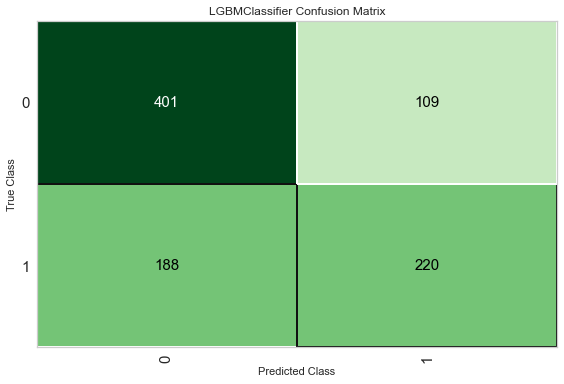

In [45]:
plot_model(lightgbm, plot = 'confusion_matrix')

# Teste 2: Doc2vec + Data Augmentation

- Pre-processamento: Remocao de stopwords, emojis e pontuacao
- Data Augmentatation: Sim
- Vetrizacao: doc2vec
- Selecao de Atributos: Nao

## Carregando o dataset pre-processado

In [12]:
dataset = pd.read_csv('C:/Users/lmb3/source/repos/OurClassifier/pycaret tutorials/data_processed/stopwordPuncEmojitRemoval_dataset.csv', index_col=0)

In [13]:
dataset

,text,misinformation,pre_processed_text
0,"No dia 07 de Outubro, quando for votar, não es...",1,no dia 07 outubro votar esqueça esquerdopatas ...
1,Devido a aborrecimentos nas varias redes socia...,0,devido aborrecimentos varias redes sociais pos...
2,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0,eu gostaria pedir todos grupos entrem neste li...
3,Como são as coisas.\nChefe do jacaré aparece n...,1,como coisas chefe jacaré aparece video baleado...
4,A ratoeira funcionou mais a ratazana aguentou ...,0,a ratoeira funcionou ratazana aguentou dor cal...
...,...,...,...
4583,Amoedo - Itaú - Metacapitalistas (George Soros...,1,amoedo itaú metacapitalistas george soros gove...
4584,*BEM GALERA... O VIDEO DA PSICOLOGIA REVERSA P...,0,bem galera video psicologia reversa ajudar pr...
4585,DIVULGUEM ESSE VIDEO PARA QUE TODOS SAIBAM QUE...,1,divulguem video todos saibam bolsonaro 🇧🇷
4586,https://www.oantagonista.com/brasil/exclusivo-...,0,www oantagonista exclusivo bolsonaro faz nova ...


In [14]:
#Mudando o nome da coluna prpcessed_text e dropando o texto original
dataset.drop('text',axis=1, inplace=True)
dataset.rename(columns = {'pre_processed_text':'text'}, inplace = True)
dataset

,misinformation,text
0,1,no dia 07 outubro votar esqueça esquerdopatas ...
1,0,devido aborrecimentos varias redes sociais pos...
2,0,eu gostaria pedir todos grupos entrem neste li...
3,1,como coisas chefe jacaré aparece video baleado...
4,0,a ratoeira funcionou ratazana aguentou dor cal...
...,...,...
4583,1,amoedo itaú metacapitalistas george soros gove...
4584,0,bem galera video psicologia reversa ajudar pr...
4585,1,divulguem video todos saibam bolsonaro 🇧🇷
4586,0,www oantagonista exclusivo bolsonaro faz nova ...


## Data Augemntation

In [15]:
def random_deletion(words, p):
    '''
    Function to randomly delete words from a srting
    Input: a string and a number between 0 and 1
    Retrun: The string with deleted words
    '''
    words = words.split()
    
    #obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    #randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    #if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence

def swap_word(new_words):
    '''
    Function to randomly change the position of two words in a string
    Input: a string 
    Retrun: The string with two swaped words
    '''
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        
        if counter > 3:
            return new_words
    
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

def random_swap(words, n):
    '''
    Function to swap position of two words in a string N times
    Input: a string 
    Retrun: The string with N two swaped words
    '''
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        new_words = swap_word(new_words)
        
    sentence = ' '.join(new_words)
    
    return sentence

def augmenter(text_series,label_series):
    '''
    Function to augment a string four times, alternating ramndomly between random swap and random deletion
    Input: a text in pandas series format and it's label
    Retrun: a dataframe objetct with the augmented text and its label
    '''
    augmented_text_df = pd.DataFrame(columns = ['text','misinformation']) #dataframe inicialization

    n_augs = 4 #number of agumentations performed
    for index in text_series.index:
        text = text_series.loc[index]
        label = label_series.loc[index]
        for i in range(n_augs):
            decider = random.uniform(0, 1) #Random number to decide wether function will be applied
            if decider < 0.5:
                new_text = random_deletion(text,random.uniform(0, 0.5)) #p probablity only goes up to 0.5
                augmented_text_df = augmented_text_df.append({'text':new_text,'misinformation':label},ignore_index=True)
            else:
                new_text = random_swap(text,random.randrange(2,int(len(text)/2))) #swaps are only executed up to half the string lenght
                augmented_text_df = augmented_text_df.append({'text':new_text,'misinformation':label},ignore_index=True)
    

    
    return augmented_text_df

In [16]:
#Division in train an test to avoid appying augmentation to the test dataset
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['misinformation'], test_size=0.2, 
                                                    stratify=dataset['misinformation'], random_state=42)

# Back to DataFrame from array
train_valid_df = pd.DataFrame(X_train, columns = ['text'])
train_valid_df.insert(len(train_valid_df.columns), 'misinformation',  y_train)

test_df = pd.DataFrame(X_test, columns = ['text'])
test_df.insert(len(test_df.columns), 'misinformation',  y_test)

In [17]:
train_valid_df

,text,misinformation
3371,mdb marcelo miranda voltam atrás declara nova...,0
700,olha quanto avançamos liga nessa limpeza dilma...,1
884,avisem correndo todos amigos parentes nordeste...,1
301,meu irmão lapada urnas japao encerradas veja r...,0
3843,recebi postagem atendi pedido b l s n r n l p...,0
...,...,...
2194,o chamou jesus travesti pedindo voto candidato,1
2231,u r g n t fhc temer ameaçando pessoalmente ju...,1
3205,ontem agredida dentro faculdade una devido des...,1
358,além roubar gente quer gente faça doação,1


In [18]:
test_df

,text,misinformation
2309,chat whatsapp fiscal psl amapá grupo apenas el...,0
406,bom dia boas notícias brasil nestes primeiros ...,1
1467,eu votar meio meio pouco pt pouco bolsonaro as...,0
1437,atenção documento congresso eua ontem outubro...,1
1268,cenas malhação tse vai fazer nada qto olha glo...,1
...,...,...
3600,a gang planejando falso atentado culpa bolsona...,1
1320,governador paraíba reúne funcionários públicos...,1
427,eu preocupação deste áudio fazer ter poder vol...,1
4577,desabafo desabafo mãe assino embaixo recomendo...,1


In [19]:
#Applying the agumentation and uniting it with the train dataset. Shuffling is also applyed
augmented_text_df = augmenter(train_valid_df['text'],train_valid_df['misinformation'])
augmented_text_df = augmented_text_df.sample(frac=1, random_state=42)
augmented_text_df = augmented_text_df.reset_index(drop=True)
augmented_text_df

,text,misinformation
0,lula amam ainda mostrem amigos parentes para,0
1,paz senhor belém 01 09 2018 judeu evangelho po...,0
2,pt r recebe menina bolsa 17 ainda sarro 1 estr...,1
3,apoio roberto joão fundador bolsonaro com amoê...,0
4,sergio curitiba urgente atenção moro congresso...,1
...,...,...
14675,filho ódio chamou repórter puta pessoas lo fal...,1
14676,família quadra 303 sul alameda 03 casa 47 palm...,0
14677,grupo whatsapp link whatsapp entrar com acesse...,0
14678,carro estacionado tal compartilhar etc carro d...,0


In [20]:
# Train augmented dataser and test dataset are united
new_text_df = pd.concat([test_df,augmented_text_df])
new_text_df = new_text_df.reset_index(drop=True)
new_text_df

,text,misinformation
0,chat whatsapp fiscal psl amapá grupo apenas el...,0
1,bom dia boas notícias brasil nestes primeiros ...,1
2,eu votar meio meio pouco pt pouco bolsonaro as...,0
3,atenção documento congresso eua ontem outubro...,1
4,cenas malhação tse vai fazer nada qto olha glo...,1
...,...,...
15593,filho ódio chamou repórter puta pessoas lo fal...,1
15594,família quadra 303 sul alameda 03 casa 47 palm...,0
15595,grupo whatsapp link whatsapp entrar com acesse...,0
15596,carro estacionado tal compartilhar etc carro d...,0


## Doc2Vec

In [21]:
def doc2vec(text_df):

    list_text = list(text_df['text'])
    for (index, text) in enumerate(list_text):
        if type(text) is list:
            text = " ".join(text)
        text = [i for i in text.split()]
        list_text[index] = text
    text_df.drop('text', axis=1, inplace=True)
    text_df['text'] = list_text

    data = [d for d in list(text_df['text'])]

    def tagged_document(list_of_list_of_words):
        for i, list_of_words in enumerate(list_of_list_of_words):
            yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
    
    data_for_training = list(tagged_document(data))
    
    model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=2, epochs=50)
    model.build_vocab(data_for_training)
    model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)
    
    def vec_for_learning(doc2vec_model, tagged_docs):
        targets, regressors = zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words)) for doc in tagged_docs])
        return targets, regressors

    targets, X_doc2vec_train = vec_for_learning(model, data_for_training)
    
    d2v_df = pd.DataFrame(X_doc2vec_train)
    d2v_df.insert(len(d2v_df.columns), 'target',  text_df['misinformation'].reset_index(drop=True))
    return d2v_df

In [22]:
#doc2vec applied in the whole data
d2v_df = doc2vec(new_text_df)
d2v_df

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,target
0,-0.162970,0.044332,-0.063446,-0.060508,-0.252905,-0.054686,-0.015632,-0.030329,0.023665,0.117172,...,0.153042,-0.087030,0.052587,-0.083447,-0.106810,0.250701,0.049284,0.001122,0.184891,0
1,-0.014393,0.050767,-0.122540,0.252106,-0.815068,-0.156877,-0.073900,-0.280442,-0.161983,0.145832,...,0.717706,-0.343343,0.059818,0.310270,-0.016617,-0.002159,0.444423,0.884867,0.076759,1
2,-0.087644,-0.118012,-0.208905,0.110754,-0.084891,0.046676,0.125642,-0.067123,-0.100563,-0.004394,...,0.235382,-0.266520,0.135224,0.213969,-0.015430,0.417536,0.008874,0.072084,0.216828,0
3,0.263312,0.007413,0.191229,0.102670,0.217091,-0.431299,0.099799,-0.217022,-0.335439,0.178400,...,0.226049,-0.019476,-0.133403,-0.493085,0.220083,-0.150663,0.436689,0.134750,0.141714,1
4,-0.460814,-0.261879,0.411099,-0.381987,-0.278771,0.153776,0.293771,-0.073579,0.215639,0.150572,...,0.176524,-0.438823,-0.042564,-0.370801,-0.031886,0.239307,-0.084357,-0.196122,-0.005110,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15593,0.000252,-0.101638,-0.621520,0.468487,-0.568438,0.214996,-0.021407,-0.163055,0.013002,-0.007542,...,0.205534,-0.123629,0.228003,-0.219837,-0.151350,0.324633,0.215545,0.299575,0.312897,1
15594,-0.262810,-0.248659,-0.115388,0.108609,0.026515,0.259005,-0.130889,-0.059375,0.090461,0.045202,...,-0.047455,-0.158591,0.076586,-0.296852,-0.178053,0.017988,-0.070920,0.289894,0.039724,0
15595,-0.058140,-0.003489,-0.023680,0.011495,-0.112081,0.067122,-0.028427,0.030053,0.015096,0.006503,...,0.034840,-0.040487,0.012071,-0.059345,-0.001502,0.037826,0.037116,0.014514,0.073544,0
15596,-0.416434,-0.279036,0.029207,0.076164,-0.554338,-0.248981,-0.388520,-0.000439,0.280599,0.212736,...,0.039865,0.574577,-0.143867,-0.211966,-0.015034,0.343120,0.211168,-0.085630,-0.067320,0


## Data Holdout

In [23]:
#Separating the train and test dataset again
data_test = d2v_df.loc[range(len(test_df)),:]
data_train_valid = d2v_df.drop(data_test.index)
data_test.reset_index(inplace=True, drop=True)
data_train_valid.reset_index(inplace=True, drop=True)

In [24]:
print('Dados para treino e validacao:')
data_train_valid

Dados para treino e validacao:


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,target
0,-0.150680,-0.019078,-0.098087,0.004988,-0.266348,0.030804,-0.144571,0.004867,0.073445,-0.071021,...,0.182041,-0.019282,-0.041394,-0.034874,0.060120,0.016722,0.115195,0.030043,0.042736,0
1,-0.795629,0.284936,-0.005676,-0.051839,-0.450721,0.983369,0.080308,0.106065,0.389419,-0.036037,...,0.163653,-0.163235,-0.214186,-0.003780,0.455138,0.642022,-0.143476,-0.175413,-0.018604,0
2,-0.108249,-0.295122,-0.209668,-0.268260,-0.108796,0.305139,-0.069247,0.370304,0.233511,-0.282086,...,0.209697,0.144487,0.091996,0.109991,-0.014473,0.013662,0.153398,0.178813,-0.164272,1
3,-0.416223,0.007966,-0.085605,-0.019871,-0.361480,-0.251670,-0.141508,0.069554,-0.273698,-0.069968,...,0.325398,-0.227389,-0.016118,-0.116609,-0.175592,-0.245073,0.133246,0.153759,-0.179374,0
4,0.011776,0.079100,-0.268082,-0.145300,0.106696,-0.123019,-0.168870,-0.030012,0.079727,0.080928,...,0.268281,-0.137955,0.079429,-0.447684,0.107505,0.006170,0.176194,-0.111049,-0.029777,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14675,0.000252,-0.101638,-0.621520,0.468487,-0.568438,0.214996,-0.021407,-0.163055,0.013002,-0.007542,...,0.205534,-0.123629,0.228003,-0.219837,-0.151350,0.324633,0.215545,0.299575,0.312897,1
14676,-0.262810,-0.248659,-0.115388,0.108609,0.026515,0.259005,-0.130889,-0.059375,0.090461,0.045202,...,-0.047455,-0.158591,0.076586,-0.296852,-0.178053,0.017988,-0.070920,0.289894,0.039724,0
14677,-0.058140,-0.003489,-0.023680,0.011495,-0.112081,0.067122,-0.028427,0.030053,0.015096,0.006503,...,0.034840,-0.040487,0.012071,-0.059345,-0.001502,0.037826,0.037116,0.014514,0.073544,0
14678,-0.416434,-0.279036,0.029207,0.076164,-0.554338,-0.248981,-0.388520,-0.000439,0.280599,0.212736,...,0.039865,0.574577,-0.143867,-0.211966,-0.015034,0.343120,0.211168,-0.085630,-0.067320,0


In [25]:
print('Dados nao vistos para predicao:')
data_test

Dados nao vistos para predicao:


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,target
0,-0.162970,0.044332,-0.063446,-0.060508,-0.252905,-0.054686,-0.015632,-0.030329,0.023665,0.117172,...,0.153042,-0.087030,0.052587,-0.083447,-0.106810,0.250701,0.049284,0.001122,0.184891,0
1,-0.014393,0.050767,-0.122540,0.252106,-0.815068,-0.156877,-0.073900,-0.280442,-0.161983,0.145832,...,0.717706,-0.343343,0.059818,0.310270,-0.016617,-0.002159,0.444423,0.884867,0.076759,1
2,-0.087644,-0.118012,-0.208905,0.110754,-0.084891,0.046676,0.125642,-0.067123,-0.100563,-0.004394,...,0.235382,-0.266520,0.135224,0.213969,-0.015430,0.417536,0.008874,0.072084,0.216828,0
3,0.263312,0.007413,0.191229,0.102670,0.217091,-0.431299,0.099799,-0.217022,-0.335439,0.178400,...,0.226049,-0.019476,-0.133403,-0.493085,0.220083,-0.150663,0.436689,0.134750,0.141714,1
4,-0.460814,-0.261879,0.411099,-0.381987,-0.278771,0.153776,0.293771,-0.073579,0.215639,0.150572,...,0.176524,-0.438823,-0.042564,-0.370801,-0.031886,0.239307,-0.084357,-0.196122,-0.005110,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.055043,-0.297148,0.111642,0.145741,-0.097136,0.154453,-0.059475,-0.261351,-0.040386,0.043890,...,-0.052621,0.088659,0.128640,0.045332,-0.089241,0.131443,-0.145397,-0.226750,0.207169,1
914,-0.015748,-0.099452,-0.139853,0.123232,-0.173011,-0.076977,-0.072528,-0.414326,-0.174531,-0.226393,...,0.032821,0.021008,-0.233834,-0.053728,0.262804,0.419550,-0.255945,-0.031633,0.022352,1
915,0.227958,0.173495,0.189432,0.168053,0.022553,-0.129337,-0.273302,-0.157387,0.153389,-0.073076,...,0.180271,-0.324079,-0.091310,-0.742272,-0.387647,0.145396,0.081382,-0.331902,-0.250965,1
916,-2.621274,0.896445,-0.355414,-0.203864,-1.177636,0.237522,-0.472487,0.117656,1.583524,0.844057,...,0.272155,-1.809046,-0.080934,0.851744,0.203415,0.057443,0.391779,-0.351790,0.277226,1


## Modelos

In [26]:
doc2vec_02 = setup(data = data_train_valid, target = 'target',use_gpu=True,train_size=0.99999) 
#O pycaret não aceita 1 como entrada, então foi feito o improviso de usar um float proximo a 2

,Description,Value
0,session_id,3997
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(14680, 301)"
5,Missing Values,False
6,Numeric Features,300
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## Treino e Validcao

In [27]:
best_model_doc2vec_02 = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8375,0.9000,0.7390,0.8767,0.8019,0.6659,0.6730,5.2710
xgboost,Extreme Gradient Boosting,0.7880,0.8711,0.7015,0.7978,0.7464,0.5656,0.5691,2.2640
catboost,CatBoost Classifier,0.7847,0.8692,0.6529,0.8270,0.7296,0.5549,0.5657,25.0390
lightgbm,Light Gradient Boosting Machine,0.7644,0.8438,0.6393,0.7912,0.7071,0.5137,0.5219,2.9750
et,Extra Trees Classifier,0.7861,0.8679,0.5781,0.9079,0.7062,0.5507,0.5856,2.1370
rf,Random Forest Classifier,0.7695,0.8384,0.5790,0.8565,0.6908,0.5178,0.5431,3.2180
gbc,Gradient Boosting Classifier,0.7180,0.7826,0.5390,0.7575,0.6296,0.4123,0.4280,88.0950
svm,SVM - Linear Kernel,0.6979,0.0000,0.5516,0.7092,0.6182,0.3750,0.3848,0.6090
lr,Logistic Regression,0.6985,0.7581,0.5335,0.7168,0.6115,0.3738,0.3848,0.9710
ada,Ada Boost Classifier,0.6676,0.7194,0.5268,0.6582,0.5848,0.3134,0.3190,17.2220


## Teste

In [28]:
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8331,0.8945,0.7202,0.8837,0.7936,0.6559,0.6656
1,0.8399,0.9046,0.7477,0.8748,0.8063,0.6713,0.6773
2,0.8215,0.8867,0.7044,0.8696,0.7783,0.6317,0.6415
3,0.8488,0.9096,0.7672,0.8774,0.8186,0.6899,0.6945
4,0.8154,0.8910,0.7274,0.8363,0.7781,0.6213,0.6258
5,0.8454,0.9038,0.7381,0.8959,0.8094,0.6813,0.6904
6,0.8420,0.8999,0.7473,0.8793,0.8079,0.6752,0.6816
7,0.8358,0.9071,0.7443,0.8679,0.8013,0.6628,0.6685
8,0.8420,0.9022,0.7443,0.8820,0.8073,0.6750,0.6820
9,0.8514,0.9004,0.7489,0.9006,0.8177,0.6941,0.7025


In [29]:
unseen_predictions = predict_model(knn, data=data_test)
print(classification_report(unseen_predictions['target'].astype('int'), unseen_predictions['Label'].astype('int')))

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       510
           1       0.65      0.48      0.55       408

    accuracy                           0.65       918
   macro avg       0.65      0.64      0.63       918
weighted avg       0.65      0.65      0.64       918



## Avaliacao de erro
**Obs: aplicação futura**

In [30]:
got_wrong = new_text_df['text'].iloc[range(len(test_df))][unseen_predictions['target'].astype('int') != unseen_predictions['Label'].astype('int')]
got_right = new_text_df['text'].iloc[range(len(test_df))][unseen_predictions['target'].astype('int') == unseen_predictions['Label'].astype('int')]

# Teste 3: TFIDF + Feature Selection

- Pre-processamento: Remoção de Stopwords. Mantidos Emojis e Pontuação
- Data Augmentatation: Não
- Vetrizacao: TFIDF
- Selecao de Atributos: Chi-quadradado

In [31]:
dataset = pd.read_csv('C:/Users/lmb3/source/repos/OurClassifier/pycaret tutorials/data_processed/stopwordPuncEmojitRemoval_dataset.csv', index_col=0)

In [32]:
dataset

,text,misinformation,pre_processed_text
0,"No dia 07 de Outubro, quando for votar, não es...",1,no dia 07 outubro votar esqueça esquerdopatas ...
1,Devido a aborrecimentos nas varias redes socia...,0,devido aborrecimentos varias redes sociais pos...
2,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0,eu gostaria pedir todos grupos entrem neste li...
3,Como são as coisas.\nChefe do jacaré aparece n...,1,como coisas chefe jacaré aparece video baleado...
4,A ratoeira funcionou mais a ratazana aguentou ...,0,a ratoeira funcionou ratazana aguentou dor cal...
...,...,...,...
4583,Amoedo - Itaú - Metacapitalistas (George Soros...,1,amoedo itaú metacapitalistas george soros gove...
4584,*BEM GALERA... O VIDEO DA PSICOLOGIA REVERSA P...,0,bem galera video psicologia reversa ajudar pr...
4585,DIVULGUEM ESSE VIDEO PARA QUE TODOS SAIBAM QUE...,1,divulguem video todos saibam bolsonaro 🇧🇷
4586,https://www.oantagonista.com/brasil/exclusivo-...,0,www oantagonista exclusivo bolsonaro faz nova ...


In [33]:
#Mudando o nome da coluna prpcessed_text e dropando o texto original
dataset.drop('text',axis=1, inplace=True)
dataset.rename(columns = {'pre_processed_text':'text'}, inplace = True)
dataset

,misinformation,text
0,1,no dia 07 outubro votar esqueça esquerdopatas ...
1,0,devido aborrecimentos varias redes sociais pos...
2,0,eu gostaria pedir todos grupos entrem neste li...
3,1,como coisas chefe jacaré aparece video baleado...
4,0,a ratoeira funcionou ratazana aguentou dor cal...
...,...,...
4583,1,amoedo itaú metacapitalistas george soros gove...
4584,0,bem galera video psicologia reversa ajudar pr...
4585,1,divulguem video todos saibam bolsonaro 🇧🇷
4586,0,www oantagonista exclusivo bolsonaro faz nova ...


## Vetorização

In [34]:
X = dataset['text']
y = dataset['misinformation']

In [35]:
#TFIDF
vectorizer_tfidf = TfidfVectorizer(ngram_range = (1,3))
tfidf_transformer = vectorizer_tfidf.fit(X)
tfidf_vect = tfidf_transformer.transform(X)
# Transformando a saída da vetorização para DataFrame devido ao formato de entrada pedido pelo pycaret
tfidf_lsit = tfidf_vect.toarray()
tfidf_df = pd.DataFrame(data=tfidf_lsit,columns = tfidf_transformer.get_feature_names())
y = y.reset_index(drop=True)
tfidf_df.insert(len(tfidf_df.columns), 'target', y)
tfidf_df

,00,00 00,00 00 perfis,00 0000,00 0000 vídeo,00 05,00 05 latas,00 12,00 12 00,00 17,...,ɴua pelada ɴao,φue,φue deɨxa,φue deɨxa letra,ссср,ссср mariellevive,ссср mariellevive golpistas,шнатѕаррѕ,шнатѕаррѕ com,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Feature Selection

In [36]:
bestfeatures_chi2 = chi2(tfidf_df.iloc[:,:-1], tfidf_df.iloc[:,-1])

# Criação do Dataframe
dfscores_chi2 = pd.DataFrame(bestfeatures_chi2[0])
dfpvalues_chi2 = pd.DataFrame(bestfeatures_chi2[1])
dfcolumns_chi2 = pd.DataFrame(tfidf_df.iloc[:,:-1].columns)
featureScores_chi2 = pd.concat([dfcolumns_chi2,dfscores_chi2,dfpvalues_chi2],axis=1)
featureScores_chi2.columns = ['Atributo','Score','P-valor']

# Seleção dos 10000 melhores atributos
tfidf_chi_df = tfidf_df.loc[:,featureScores_chi2.sort_values('P-valor',ascending = True)[:10000]['Atributo']]
y = y.reset_index(drop=True)
tfidf_chi_df.insert(len(tfidf_chi_df.columns), 'target', y)
tfidf_chi_df

,whatsapp,chat,chat whatsapp,whatsapp chat whatsapp,whatsapp chat,grupo whatsapp chat,entrar grupo,link entrar,link entrar grupo,chat whatsapp com,...,dei desafio,desafio dar deslike,desafio dar,empresas param,máximo amigos grupos,falar merda apoiando,assim empresas param,saqueiam país,achar falar,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Modelos

In [37]:
tfidf_01 = setup(data = tfidf_chi_df, target = 'target',use_gpu=True,numeric_features=tfidf_chi_df.columns.tolist()[:-1],
                 data_split_stratify=True, train_size=0.8, session_id=42)

,Description,Value
0,session_id,42
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4588, 10001)"
5,Missing Values,False
6,Numeric Features,10000
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## Treino e Validcao

In [38]:
best_model_tfidf_01 = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.8782,0.8758,0.8512,0.8725,0.8613,0.7528,0.7535,0.3240
svm,SVM - Linear Kernel,0.8044,0.0000,0.7182,0.8296,0.7630,0.5986,0.6101,1.1740
ridge,Ridge Classifier,0.7940,0.0000,0.6571,0.8459,0.7391,0.5735,0.5864,0.7080
et,Extra Trees Classifier,0.7815,0.8745,0.6369,0.8336,0.7213,0.5470,0.5609,3.3840
catboost,CatBoost Classifier,0.7708,0.8535,0.6590,0.7920,0.7190,0.5283,0.5350,20.1590
lightgbm,Light Gradient Boosting Machine,0.7583,0.8338,0.6853,0.7509,0.7161,0.5065,0.5086,0.7110
xgboost,Extreme Gradient Boosting,0.7586,0.8393,0.6540,0.7698,0.7069,0.5040,0.5091,4.1860
rf,Random Forest Classifier,0.7700,0.8730,0.5977,0.8400,0.6978,0.5207,0.5408,2.1920
dt,Decision Tree Classifier,0.7123,0.7056,0.6700,0.6792,0.6740,0.4166,0.4171,2.5970
gbc,Gradient Boosting Classifier,0.7330,0.8136,0.5701,0.7713,0.6549,0.4451,0.4591,13.2790


## Teste

In [39]:
nb = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8420,0.8420,0.8160,0.8261,0.8210,0.6795,0.6796
1,0.8801,0.8792,0.8712,0.8606,0.8659,0.7575,0.7575
2,0.9019,0.8976,0.8589,0.9150,0.8861,0.8001,0.8013
3,0.8937,0.8921,0.8773,0.8827,0.8800,0.7846,0.7847
4,0.8856,0.8835,0.8650,0.8758,0.8704,0.7679,0.7680
5,0.8910,0.8872,0.8528,0.8968,0.8742,0.7782,0.7789
6,0.8965,0.8955,0.8896,0.8788,0.8841,0.7906,0.7906
7,0.8801,0.8808,0.8902,0.8488,0.8690,0.7586,0.7593
8,0.8583,0.8520,0.7927,0.8784,0.8333,0.7107,0.7135
9,0.8529,0.8477,0.7988,0.8618,0.8291,0.7003,0.7018


In [40]:
predict_model(nb);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.8671,0.8642,0.8064,0.8844,0.8436,0.7285,0.7308


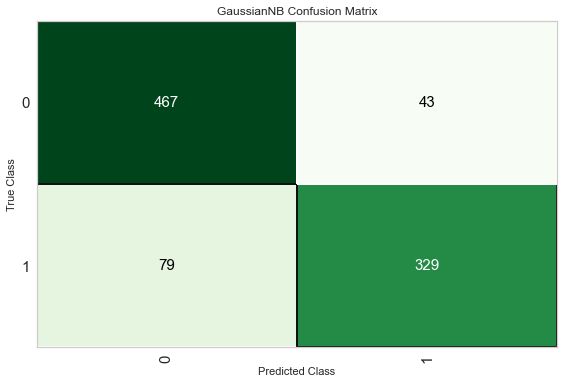

In [41]:
plot_model(nb, plot = 'confusion_matrix')

# Teste 4: TFIDF + Feature Selection

- Pre-processamento: Tudo mantido
- Data Augmentatation: Nao
- Vetrizacao: TFIDF
- Selecao de Atributos: Chi-quadradado

## Carregando o dataset pre-processado

In [3]:
dataset = pd.read_csv('C:/Users/lmb3/source/repos/OurClassifier/pycaret tutorials/data_processed/stopwordPunctEmojiKeep_dataset.csv', index_col=0)

In [4]:
dataset

,text,misinformation,pre_processed_text
0,"No dia 07 de Outubro, quando for votar, não es...",1,"no dia 07 de outubro , quando for votar , não ..."
1,Devido a aborrecimentos nas varias redes socia...,0,devido a aborrecimentos nas varias redes socia...
2,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0,eu gostaria de pedir a todos do grupos entrem ...
3,Como são as coisas.\nChefe do jacaré aparece n...,1,como são as coisas . \n chefe do jacaré aparec...
4,A ratoeira funcionou mais a ratazana aguentou ...,0,a ratoeira funcionou mais a ratazana aguentou ...
...,...,...,...
4583,Amoedo - Itaú - Metacapitalistas (George Soros...,1,amoedo - itaú - metacapitalistas ( george soro...
4584,*BEM GALERA... O VIDEO DA PSICOLOGIA REVERSA P...,0,* bem galera . . . o video da psicologia reve...
4585,DIVULGUEM ESSE VIDEO PARA QUE TODOS SAIBAM QUE...,1,divulguem esse video para que todos saibam que...
4586,https://www.oantagonista.com/brasil/exclusivo-...,0,www . oantagonista . com * exclusivo : bolsona...


In [5]:
#Mudando o nome da coluna prpcessed_text e dropando o texto original
dataset.drop('text',axis=1, inplace=True)
dataset.rename(columns = {'pre_processed_text':'text'}, inplace = True)
dataset

,misinformation,text
0,1,"no dia 07 de outubro , quando for votar , não ..."
1,0,devido a aborrecimentos nas varias redes socia...
2,0,eu gostaria de pedir a todos do grupos entrem ...
3,1,como são as coisas . \n chefe do jacaré aparec...
4,0,a ratoeira funcionou mais a ratazana aguentou ...
...,...,...
4583,1,amoedo - itaú - metacapitalistas ( george soro...
4584,0,* bem galera . . . o video da psicologia reve...
4585,1,divulguem esse video para que todos saibam que...
4586,0,www . oantagonista . com * exclusivo : bolsona...


## Vetorização

In [6]:
X = dataset['text']
y = dataset['misinformation']

In [7]:
#TFIDF
vectorizer_tfidf = TfidfVectorizer(ngram_range = (1,3))#,max_features=20000
tfidf_transformer = vectorizer_tfidf.fit(X)
tfidf_vect = tfidf_transformer.transform(X)
# Transformando a saída da vetorização para DataFrame devido ao formato de entrada pedido pelo pycaret
tfidf_lsit = tfidf_vect.toarray()
tfidf_df = pd.DataFrame(data=tfidf_lsit,columns = tfidf_transformer.get_feature_names()) #,columns = tfidf_transformer.get_feature_names()
y = y.reset_index(drop=True)
tfidf_df.insert(len(tfidf_df.columns), 'target', y)
tfidf_df

,00,00 00,00 00 em,00 0000,00 0000 vídeo,00 19,00 19 de,00 27,00 27 10,00 37,00 37 50,00 além,00 além desse,00 as,00 as 12,00 atendimento,00 atendimento será,00 auxílio,00 auxílio cultural,00 auxílio educação,00 auxílio moradia,00 auxílio paletó,00 auxílio restaurante,00 auxílio saúde,00 bombacha,00 bombacha 150,00 bota,00 bota 250,00 cada,00 cada vez,00 caetano,00 caetano veloso,00 cem,00 cem mil,00 chapéu,00 chapéu 190,00 claudia,00 claudia leitte,00 cláudia,00 cláudia raia,00 combustível,00 combustível 22,00 conseguiu,00 conseguiu milhão,00 da,00 da manhã,00 de,00 de bolsa,00 de dolares,00 de forma,00 decidi,00 decidi que,00 desemprego,00 desemprego era,00 deve,00 deve ser,00 do,00 do dia,00 em,00 em créditos,00 em seus,00 enquanto,00 enquanto nos,00 essa,00 essa esquerda,00 estaremos,00 estaremos doando,00 faleceram,00 faleceram no,00 frete,00 frete para,00 gastos,00 gastos esta,00 hora,00 hora agora,00 horas,00 horas brasil,00 horas chat,00 horas com,00 horas da,00 horas envie,00 horas jair,00 horas minuto,00 horas saindo,00 horas traga,00 horas vem,00 horas venha,00 horário,00 horário limite,00 hrs,00 hrs link,00 hrs tomaremos,00 hs,00 hs na,00 hs uma,00 humberto,00 humberto gessinger,00 ia,00 ia ficar,00 inscrições,00 inscrições 12,00 interessados,00 interessados chamar,00 local,00 local praça,00 mais,00 mais um,00 maria,00 maria bethânia,00 mas,00 mas como,00 mas entrar,00 mas problema,00 medindo,00 medindo por,00 metros,00 metros em,00 mil,00 mil reais,00 motivo,00 motivo achei,00 muito,00 muito sem,00 na,00 na avenida,00 na praça,00 no,00 no banco,00 no cartão,00 no kilo,00 noventa,00 noventa mil,00 não,00 não possível,00 paga,00 paga 750,00 para,00 para arriscar,00 para bancar,00 para bandido,00 para cada,00 para campanha,00 para custear,00 para financiar,00 para haddad,00 para manter,00 para preparar,00 para rezarmos,00 para salvar,00 para soldado,00 para sustentar,00 para todos,00 paraíba,00 paraíba bolsonaro,00 passagens,00 passagens aéreas,00 pessoas,00 pessoas andando,00 por,00 por 50,00 por exemplo,00 por extenso,00 por pessoa,00 por sessão,00 porque,00 porque se,00 reais,00 reais 2021,00 reais aluguel,00 reais cerveja,00 reais para,00 reais será,00 rita,00 rita lee,00 salário,00 salário 94,00 salário dava,00 salário dá,00 sargentos,00 sargentos temporários,00 se,00 se gastarmos,00 será,00 será onde,00 sessão,00 sessão vezes,00 são,00 são 05,00 tico,00 tico santa,00 tomaremos,00 tomaremos as,00 transporte,00 transporte lanche,00 trezentos,00 trezentos sessenta,00 trinta,00 trinta cinco,00 trinta mil,00 uma,00 uma carreata,00 varejo,00 varejo promoção,00 verba,00 verba de,00 vinte,00 vinte três,00 às,00 às 17,00 às 22,000,000 00,000 00 auxílio,000 00 cem,000 00 combustível,000 00 de,000 00 deve,000 00 gastos,000 00 mais,000 00 no,000 00 noventa,000 00 para,000 00 passagens,000 00 reais,000 00 será,000 00 trezentos,000 00 trinta,000 00 vinte,000 000,000 000 00,000 000 de,000 000 dois,000 000 milhões,000 000 votos,000 500,000 500 800,000 700,000 700 cartao,000 900,000 900 cartao,000 ainda,000 ainda lhe,000 alckmin,000 alckmin 900,000 amoedo,000 amoedo 600,000 anos,000 anos sua,000 assassinatos,000 assassinatos por,...,últimos ditadores soviéticos,últimos dois,últimos dois governos,últimos dois meses,últimos precisaram,últimos precisaram justamente,últimos tempos,últimos tempos bolsonaro,últimos tempos então,últimos tempos estamos,últimos tempos um,últimos trinta,últimos trinta quarenta,últimos áudios,últimos áudios ensinam,últimos áudios ser,única,única 100,única 100 de,única ajuda,única ajuda site,única alternativa,única alternativa único,única barbearia,única barbearia da,única chance,única chance de,única coisa,única coisa fazer,única coisa que,única coisa um,única coisa virada,única completa,única completa alienação,única de,única de todo,única dizer,única dizer ser,única esperança,única esperança acho,única exclusivamente,única exclusivamente para,única experiecia,única experiecia que,única forma,única forma

## Feature Selection

In [8]:
from sklearn.feature_selection import chi2

bestfeatures_chi2 = chi2(tfidf_df.iloc[:,:-1], tfidf_df.iloc[:,-1])

# Criação do Dataframe
dfscores_chi2 = pd.DataFrame(bestfeatures_chi2[0])
dfpvalues_chi2 = pd.DataFrame(bestfeatures_chi2[1])
dfcolumns_chi2 = pd.DataFrame(tfidf_df.iloc[:,:-1].columns)
featureScores_chi2 = pd.concat([dfcolumns_chi2,dfscores_chi2,dfpvalues_chi2],axis=1)
featureScores_chi2.columns = ['Atributo','Score','P-valor']

# Seleção dos 10000 melhores atributos
tfidf_chi_df = tfidf_df.loc[:,featureScores_chi2.sort_values('P-valor',ascending = True)[:10000]['Atributo']]
y = y.reset_index(drop=True)
tfidf_chi_df.insert(len(tfidf_chi_df.columns), 'target', y)
tfidf_chi_df

,whatsapp,whatsapp com,chat whatsapp com,chat,chat whatsapp,este link,whatsapp chat whatsapp,whatsapp chat,este link para,meu grupo,para entrar,para entrar no,link para entrar,no meu grupo,entrar no meu,acesse este,acesse este link,grupo do,grupo do whatsapp,do whatsapp chat,entrar no,meu grupo do,link para,no meu,entrar,do whatsapp,grupo,link,acesse,que,de,da,vídeo,meu,youtu,youtu be,be,pág,senador,pt,áudio,palmas,está,eles,tocantins,escolas,psl,escândalo,pesquisa,youtube com ciro,por,pioi,como,adesivaço,contra,padre,urgente,venezuela,governo,os,deslike,fim,que pt,fraude,gay,prefiro,golpe,que eles,esse vídeo,esquerda,sem,caso,país,mídia,relacionado,não,que não seja,apenas para eleitores,um fiscal,fiscal psl,assunto que,qualquer assunto,de qualquer assunto,qualquer assunto que,seja relacionado,vc também,um fiscal psl,permitido postagem de,relacionado fiscalização,permitido postagem,postagem de,postagem de qualquer,vc também um,whatsapp com seja,não seja relacionado,seja vc,com seja,assunto que não,seja relacionado fiscalização,grupo apenas,grupo apenas para,com seja vc,também um fiscal,também um,não permitido postagem,seja vc também,feira,se,eleitores do estado,para eleitores,repassar,não permitido,para eleitores do,nas escolas,com ciro,carreata,este vídeo,ne,comunista,online,estadual,permitido,povo,dep,mst,deslikes,apenas para,do tocantins,máximo,esse,kit,porque,praça,pois,radical,bandidos,lula,rotação,sistema,ditadura,postagem,poder,isso,kit gay,bandido,de qualquer,intervenção,capim,ao máximo,to,operação,brasil,uma,foi,video,eles estão,ciro sobre,youtu be youtu,be youtu,be youtu be,esta,países,padre marcelo,lixo,dos girassóis,praça dos girassóis,girassóis,ministro,este,tela,república,praça dos,cuba,rouanet,petista,nas,no brasil,tudo,bancos,que haddad,negativar,chineses,saber,desmascarar,fiscalização,intervenção militar,ser,dinheiro,através da,marcelo rossi,rossi,padre marcelo rossi,2011,que está,seus,mesmo,av,esse áudio,anos,lula dilma,foro,psol,verão,recebem,acabou de,urnas,ouça,quarta,rede globo,vagabundos,dia,ministro da,www urnadigital com,www urnadigital,urnadigital,urnadigital com,diretor,destruição,rotação vira tela,vira tela,rotação vira,quarta feira,drogas,deixem de,www youtube,www youtube com,farlei,olavo de carvalho,olavo de,sabia,estão,já sabe,este áudio,do que,contatos,dep estadual,sargento,acabar,caminhada,partidos,veja,dislike,capitaleca,radical porque,inteiro,ideologia de,séria,strawpoll com,strawpoll,roubado,...,10 as,cinema,mal do,recordes,que um,me dizer,nao vao,fraudando,banheiro,todos os outros,bolsonaro isso,de onde,pt diz que,pt diz,amazonino,140 candidatos deputado,eleger aproximadamente de,então votar somente,as demais bancadas,de 120 140,120 140 candidatos,eleger aproximadamente,120 140,então votar,140 candidatos,eleitos mesma,de vc uma,se cada eleitor,federal isso,partidos do blocão,do blocão,ou contra ele,ou então votar,superior todas,que muitos candidatos,superior todas as,forte com,muitos candidatos de,forte com bolsonaro,mesma estratégia vale,mesma estratégia,de partidos do,eleitor que votar,eleitos mesma estratégia,tornaria bancada do,somente na,tornaria bancada,votar somente na,bolsonaro conseguirá eleger,conseguirá eleger aproximadamente,com bolsonaro ou,conseguirá eleger,um candidato deputado,blocão,em bolsonaro votar,bolsonaro votar,também em um,bolsonaro votar também,vale para as,aproximadamente de,vc uma bancada,cada eleitor que,bolsonaro conseguirá,legenda psl 17,deputado federal isso,aproximadamente de 120,com que muitos,vc uma,bancadas depende,votar também,bancadas depende de,candidatos de partidos,votar também em,somente na legenda,uma bancada forte,na legenda psl,estratégia vale para,demais bancadas,demais bancadas depende,estratégia vale,bancada forte com,bancada forte,rn,tá ganhando,ser em,ganha mais,tv no,que você quer,cidades do,video para que,divulguem esse video,saibam quem,saibam quem bolsonaro,esse video para,video para,todos saibam quem,com cesarsimonioficial www,cesarsimon

## Modelos

In [9]:
tfidf_02 = setup(data = tfidf_chi_df, target = 'target',use_gpu=True,numeric_features=tfidf_chi_df.columns.tolist()[:-1],
                 data_split_stratify=True, train_size=0.8, session_id=42)

,Description,Value
0,session_id,42
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4588, 10001)"
5,Missing Values,False
6,Numeric Features,10000
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## Treino e Validcao

In [10]:
best_model_tfidf_02 = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.8883,0.8896,0.8965,0.8590,0.8772,0.7748,0.7757,0.3980
svm,SVM - Linear Kernel,0.7978,0.0000,0.6760,0.8427,0.7476,0.5826,0.5946,1.4930
ridge,Ridge Classifier,0.7905,0.0000,0.6455,0.8476,0.7327,0.5655,0.5799,0.7950
lightgbm,Light Gradient Boosting Machine,0.7624,0.8339,0.6908,0.7555,0.7212,0.5149,0.5170,2.1580
catboost,CatBoost Classifier,0.7646,0.8482,0.6565,0.7807,0.7128,0.5158,0.5218,28.9970
xgboost,Extreme Gradient Boosting,0.7572,0.8391,0.6755,0.7542,0.7121,0.5034,0.5062,5.8760
et,Extra Trees Classifier,0.7787,0.8786,0.6032,0.8576,0.7077,0.5384,0.5604,3.3720
rf,Random Forest Classifier,0.7550,0.8628,0.5524,0.8430,0.6668,0.4864,0.5139,2.1790
gbc,Gradient Boosting Classifier,0.7362,0.8094,0.5830,0.7700,0.6628,0.4530,0.4654,17.6190
ada,Ada Boost Classifier,0.7144,0.7774,0.6143,0.7078,0.6564,0.4144,0.4185,4.7040


## Teste

In [11]:
nb = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8501,0.8504,0.8528,0.8176,0.8348,0.6978,0.6983
1,0.8937,0.8985,0.9141,0.8563,0.8843,0.7862,0.7877
2,0.8828,0.8835,0.8896,0.8529,0.8709,0.7637,0.7643
3,0.9101,0.9123,0.9325,0.8736,0.9021,0.8191,0.8206
4,0.9019,0.9025,0.9080,0.8757,0.8916,0.8021,0.8025
5,0.8992,0.8982,0.8896,0.8841,0.8869,0.7959,0.7960
6,0.8937,0.8939,0.8957,0.8690,0.8822,0.7854,0.7857
7,0.8937,0.8996,0.9268,0.8492,0.8863,0.7869,0.7896
8,0.8910,0.8892,0.8720,0.8827,0.8773,0.7793,0.7793
9,0.8665,0.8682,0.8841,0.8286,0.8555,0.7316,0.7330


In [12]:
predict_model(nb);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.9074,0.9056,0.8897,0.9007,0.8952,0.8123,0.8123


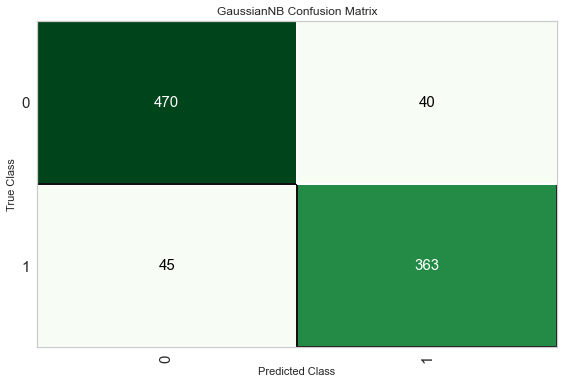

In [13]:
plot_model(nb, plot = 'confusion_matrix')

## Tuning do Modelo

**O melhor modelo encontrado foi o Gaussian Naive Bayes, por isso, este e outros modelos de naive bayes serão testados nesta etapa**

### Gaussian Naive Bayes

In [14]:
print(nb)

GaussianNB(priors=None, var_smoothing=1e-09)


In [15]:
tuned_gNB = tune_model(nb, optimize = 'F1', custom_grid = {'var_smoothing':list(np.arange(0.000000001,1,0.001))+list(np.arange(1,101,1))},
                            search_algorithm='grid')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8747,0.8848,0.8405,0.8726,0.8562,0.7452,0.7456
1,0.9155,0.9270,0.9018,0.9074,0.9046,0.8288,0.8288
2,0.8937,0.9142,0.8466,0.9079,0.8762,0.7833,0.7848
3,0.9046,0.9208,0.8834,0.9000,0.8916,0.8065,0.8066
4,0.9183,0.9362,0.8896,0.9236,0.9062,0.8338,0.8343
5,0.9074,0.9159,0.8773,0.9108,0.8938,0.8117,0.8121
6,0.8992,0.9160,0.8896,0.8841,0.8869,0.7959,0.7960
7,0.9101,0.9408,0.8659,0.9281,0.8959,0.8169,0.8185
8,0.8992,0.9078,0.8415,0.9262,0.8818,0.7943,0.7970
9,0.8828,0.8944,0.8476,0.8854,0.8660,0.7620,0.7626


In [16]:
print(tuned_gNB)

GaussianNB(priors=None, var_smoothing=0.001000001)


In [17]:
tuned_gNB2 = tune_model(tuned_gNB, optimize = 'F1', custom_grid = {'var_smoothing':list(np.arange(0.0001,0.002,0.0001))+list(np.arange(1,101,1))},
                            search_algorithm='grid')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8665,0.8730,0.8589,0.8434,0.8511,0.7301,0.7302
1,0.9101,0.9243,0.9202,0.8824,0.9009,0.8187,0.8193
2,0.8965,0.9135,0.8834,0.8834,0.8834,0.7903,0.7903
3,0.9183,0.9259,0.9202,0.8982,0.9091,0.8349,0.8351
4,0.9292,0.9391,0.9264,0.9152,0.9207,0.8567,0.8567
5,0.9019,0.9083,0.8896,0.8896,0.8896,0.8013,0.8013
6,0.9101,0.9120,0.9141,0.8869,0.9003,0.8185,0.8188
7,0.9237,0.9259,0.9329,0.9000,0.9162,0.8462,0.8467
8,0.9019,0.9010,0.8720,0.9051,0.8882,0.8009,0.8013
9,0.8747,0.8799,0.8720,0.8512,0.8614,0.7470,0.7472


In [18]:
print(tuned_gNB2)

GaussianNB(priors=None, var_smoothing=0.0005)


### Complement NB

In [19]:
from sklearn.naive_bayes import ComplementNB

cNB = create_model(ComplementNB())

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7956,0.8819,0.8712,0.7245,0.7911,0.5944,0.6041
1,0.7820,0.9024,0.9141,0.6930,0.7884,0.5722,0.5957
2,0.7493,0.8791,0.8957,0.6606,0.7604,0.5098,0.5361
3,0.7493,0.8771,0.8957,0.6606,0.7604,0.5098,0.5361
4,0.7766,0.8888,0.8957,0.6919,0.7807,0.5605,0.5800
5,0.7738,0.8931,0.8650,0.6980,0.7726,0.5527,0.5653
6,0.7384,0.8779,0.9018,0.6476,0.7538,0.4903,0.5214
7,0.7793,0.8884,0.9085,0.6930,0.7863,0.5665,0.5889
8,0.7302,0.8496,0.8476,0.6526,0.7374,0.4696,0.4866
9,0.7493,0.8634,0.8720,0.6682,0.7566,0.5073,0.5266


In [20]:
print(cNB)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)


In [21]:
tuned_cNB = tune_model(cNB, optimize = 'F1', custom_grid = {'alpha':list(np.arange(0.1,1,0.1))+list(np.arange(1,101,1)),'norm':[True,False]},
                            search_algorithm='random',n_iter=1000)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8392,0.9203,0.8957,0.7766,0.8319,0.6794,0.6857
1,0.8338,0.9451,0.9018,0.7656,0.8282,0.6693,0.6777
2,0.8229,0.9249,0.9141,0.7450,0.8209,0.6493,0.6626
3,0.8311,0.9302,0.8896,0.7672,0.8239,0.6633,0.6700
4,0.8202,0.9369,0.9264,0.7366,0.8207,0.6450,0.6621
5,0.8392,0.9401,0.8896,0.7796,0.8309,0.6790,0.6843
6,0.8283,0.9343,0.9202,0.7500,0.8264,0.6601,0.6736
7,0.8474,0.9382,0.9329,0.7727,0.8453,0.6974,0.7094
8,0.8147,0.9155,0.8720,0.7526,0.8079,0.6308,0.6372
9,0.8174,0.9154,0.9085,0.7413,0.8164,0.6385,0.6517


In [22]:
print(tuned_cNB)

ComplementNB(alpha=0.1, class_prior=None, fit_prior=True, norm=False)


In [23]:
tuned_cNB2 = tune_model(cNB, optimize = 'F1', custom_grid = {'alpha':np.arange(0,0.2,0.01),'norm':[False]},
                            search_algorithm='grid')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8283,0.9411,0.9264,0.7475,0.8274,0.6605,0.6756
1,0.8665,0.9678,0.9571,0.7879,0.8643,0.7353,0.7488
2,0.8474,0.9593,0.9632,0.7585,0.8486,0.6991,0.7195
3,0.8665,0.9607,0.9448,0.7938,0.8627,0.7347,0.7452
4,0.8365,0.9685,0.9571,0.7464,0.8387,0.6780,0.6997
5,0.8529,0.9663,0.9325,0.7795,0.8492,0.7078,0.7186
6,0.8583,0.9618,0.9509,0.7789,0.8564,0.7193,0.7333
7,0.8420,0.9607,0.9573,0.7548,0.8441,0.6883,0.7084
8,0.8420,0.9607,0.9329,0.7650,0.8407,0.6869,0.7003
9,0.8392,0.9548,0.9451,0.7561,0.8401,0.6824,0.6997


In [24]:
print(tuned_cNB2)

ComplementNB(alpha=0.0, class_prior=None, fit_prior=True, norm=False)


### Multinomial NB

In [25]:
from sklearn.naive_bayes import MultinomialNB

mNB = create_model(MultinomialNB())

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7384,0.8819,0.4847,0.8681,0.6220,0.4456,0.4900
1,0.7575,0.9024,0.4908,0.9302,0.6426,0.4844,0.5412
2,0.7602,0.8791,0.5092,0.9121,0.6535,0.4918,0.5408
3,0.7548,0.8771,0.4969,0.9101,0.6429,0.4796,0.5306
4,0.7602,0.8888,0.5399,0.8713,0.6667,0.4951,0.5297
5,0.7657,0.8931,0.5153,0.9231,0.6614,0.5034,0.5535
6,0.7684,0.8779,0.5399,0.8980,0.6743,0.5113,0.5513
7,0.7602,0.8884,0.5122,0.9130,0.6562,0.4936,0.5423
8,0.7411,0.8496,0.4695,0.9059,0.6185,0.4510,0.5069
9,0.7357,0.8634,0.4695,0.8851,0.6135,0.4401,0.4913


In [26]:
print(mNB)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [27]:
tuned_mNB = tune_model(mNB, optimize = 'F1', custom_grid = {'alpha':list(np.arange(0.1,1,0.1))+list(np.arange(1,101,1))},
                            search_algorithm='grid')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8338,0.9203,0.7301,0.8750,0.7960,0.6577,0.6654
1,0.8692,0.9451,0.7914,0.9021,0.8431,0.7318,0.7364
2,0.8365,0.9249,0.7362,0.8759,0.8000,0.6635,0.6707
3,0.8801,0.9302,0.8221,0.8993,0.8590,0.7551,0.7574
4,0.8583,0.9369,0.7853,0.8828,0.8312,0.7098,0.7134
5,0.8529,0.9401,0.7730,0.8811,0.8235,0.6983,0.7027
6,0.8665,0.9343,0.8282,0.8654,0.8464,0.7284,0.7290
7,0.8638,0.9382,0.8049,0.8800,0.8408,0.7221,0.7243
8,0.8501,0.9155,0.7439,0.9037,0.8161,0.6916,0.7009
9,0.8338,0.9154,0.7317,0.8759,0.7973,0.6584,0.6660


In [28]:
print(tuned_mNB)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


In [29]:
tuned_mNB2 = tune_model(mNB, optimize = 'F1', custom_grid = {'alpha':np.arange(0,0.2,0.01)},
                            search_algorithm='grid')#,n_iter=1000)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8556,0.9411,0.8650,0.8198,0.8418,0.7091,0.7100
1,0.8992,0.9678,0.9387,0.8500,0.8921,0.7979,0.8014
2,0.8774,0.9593,0.9141,0.8278,0.8688,0.7542,0.7575
3,0.8992,0.9607,0.9264,0.8580,0.8909,0.7974,0.7995
4,0.9101,0.9685,0.9448,0.8652,0.9032,0.8196,0.8223
5,0.9019,0.9663,0.9080,0.8757,0.8916,0.8021,0.8025
6,0.8937,0.9618,0.9264,0.8483,0.8856,0.7868,0.7894
7,0.8937,0.9607,0.9451,0.8378,0.8883,0.7877,0.7929
8,0.8828,0.9607,0.8841,0.8580,0.8709,0.7637,0.7640
9,0.8719,0.9548,0.8963,0.8305,0.8622,0.7429,0.7448


In [30]:
tuned_mNB2

MultinomialNB(alpha=0.0, class_prior=None, fit_prior=True)

### Teste de melhor modelo ajustado: Gaussian Naive Bayes

In [31]:
print(tuned_gNB2)

GaussianNB(priors=None, var_smoothing=0.0005)


In [32]:
predict_model(tuned_gNB2);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.9129,0.9281,0.8725,0.9271,0.8990,0.8225,0.8237


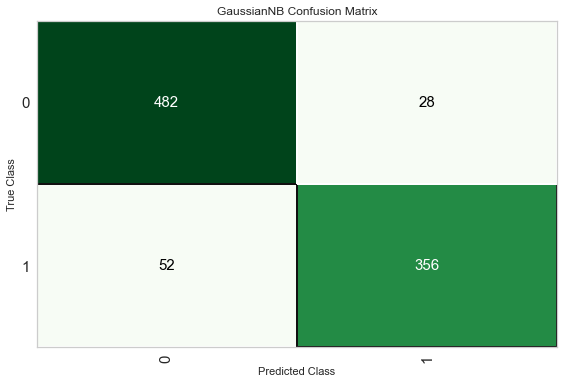

In [33]:
plot_model(tuned_gNB2, plot = 'confusion_matrix')